<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D5_NetworkCausality/W3D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D5_NetworkCausality/W3D5_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Correlations
**Week 3, Day 5: Network Causality**

**By Neuromatch Academy**

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content reviewers**: Mike X Cohen, Madineh Sarvestani, Yoni Friedman, Ella Batty, Michael Waskom

**Post-production team:** Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial objectives

*Estimated timing of tutorial: 45 min*

This is tutorial 2 on our day of examining causality. Below is the high level outline of what we'll cover today, with the sections we will focus on in this tutorial in bold:

1. Master definitions of causality
2. Understand that estimating causality is possible
3. Learn 4 different methods and understand when they fail
    1. perturbations
    2. **correlations**
    3. simultaneous fitting/regression
    5. instrumental variables

### Tutorial 2 objectives

In tutorial 1, we implemented and explored the dynamical system of neurons we will be working with throughout all of the tutorials today. We also learned about the "gold standard" of measuring causal effects through random perturbations. As random perturbations are often not possible, we will now turn to alternative methods to attempt to measure causality. We will:

- Learn how to estimate connectivity from observations assuming **correlations approximate causation**
- Show that this only works when the network is small

### Tutorial 2 setting

Often, we can't force neural activities or brain areas to be on or off. We just have to observe. Maybe we can get the correlation between two nodes -- is that good enough? The question we ask in this tutorial is **when is correlation a "good enough" substitute for causation?**

The answer is not "never", actually, but "sometimes".

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/gp4m9/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
#@title Plotting Functions

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k', s=150)
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i, j], head_width=.15,
                        width = A[i,j] / 25, shape='right', length_includes_head=True)
    ax.axis('off')

def plot_estimation_quality_vs_n_neurons(number_of_neurons):
    """
    A wrapper function that calculates correlation between true and estimated connectivity
    matrices for each number of neurons and plots

    Args:
      number_of_neurons (list): list of different number of neurons for modeling system
      corr_func (function): Function for computing correlation
    """
    corr_data = np.zeros((n_trials, len(number_of_neurons)))
    for trial in range(n_trials):
      print("simulating trial {} of {}".format(trial + 1, n_trials))
      for j, size in enumerate(number_of_neurons):
          corr = get_sys_corr(size, timesteps, trial)
          corr_data[trial, j] = corr

    corr_mean = corr_data.mean(axis=0)
    corr_std = corr_data.std(axis=0)

    plt.plot(number_of_neurons, corr_mean)
    plt.fill_between(number_of_neurons,
                     corr_mean - corr_std,
                     corr_mean + corr_std,
                     alpha=.2)
    plt.xlabel("Number of neurons")
    plt.ylabel("Correlation")
    plt.title("Similarity between A and R as a function of network size")
    plt.show()


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                     labelpad= 20, va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")


def plot_true_vs_estimated_connectivity(estimated_connectivity, true_connectivity, selected_neuron=None):
  """Visualize true vs estimated connectivity matrices

  Args:
    estimated_connectivity (ndarray): estimated connectivity (n_neurons by n_neurons)
    true_connectivity (ndarray): ground-truth connectivity (n_neurons by n_neurons)
    selected_neuron (int or None): None if plotting all connectivity, otherwise connectivity
      from selected_neuron will be shown

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  if selected_neuron is not None:
    plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
    plot_connectivity_matrix(true_connectivity[:, [selected_neuron]], ax=axs[1])
    axs[0].set_xticks([0])
    axs[1].set_xticks([0])
    axs[0].set_xticklabels([selected_neuron])
    axs[1].set_xticklabels([selected_neuron])
  else:
    plot_connectivity_matrix(estimated_connectivity, ax=axs[0])
    plot_connectivity_matrix(true_connectivity, ax=axs[1])

  axs[1].set(title="True connectivity")
  axs[0].set(title="Estimated connectivity")

In [5]:
# @title Helper Functions

def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]

The helper functions defined above are:
- `sigmoid`: computes sigmoid nonlinearity element-wise on input, from Tutorial 1
- `create_connectivity`: generates nxn causal connectivity matrix., from Tutorial 1
- `simulate_neurons`: simulates a dynamical system for the specified number of neurons and timesteps, from Tutorial 1
- `get_sys_corr`: a wrapper function for correlation calculations between A and R.

---
# Section 1: Small systems



In [6]:
# @title Video 1: Correlation vs causation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Ak4y1m7kk", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="vjBO-S7KNPI", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 1: Try to approximate causation with correlation

In small systems, correlation can look like causation. Let's attempt to recover the true connectivity matrix (A) just by correlating the neural state at each timestep with the previous state: $C=\vec{x_t}{\vec{x_{t+1}}^\top}$. 

Complete this function to estimate the connectivity matrix of a single neuron by calculating the correlation coefficients with every other neuron at the next timestep. That is, please correlate two vectors: 1) the activity of a selected neuron at time $t$ 2) The activity of all other neurons at time $t+1$.

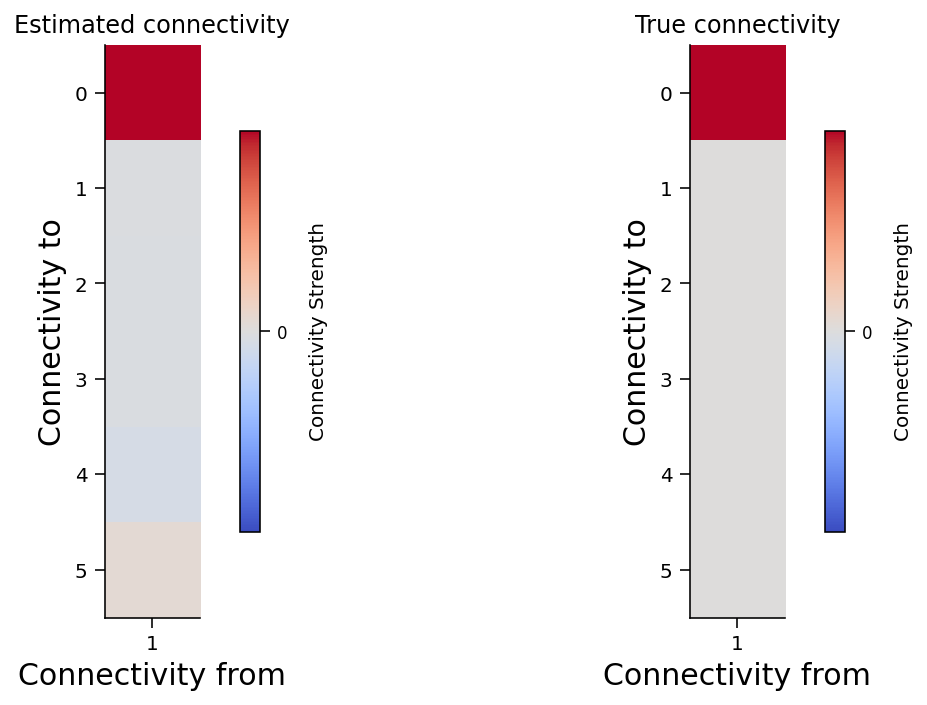

In [7]:
def compute_connectivity_from_single_neuron(X, selected_neuron):
    """
    Computes the connectivity matrix from a single neuron neurons using correlations

    Args:
        X (ndarray): the matrix of activities
        selected_neuron (int): the index of the selected neuron

    Returns:
        estimated_connectivity (ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """

    # Extract the current activity of selected_neuron, t
    current_activity = X[selected_neuron, :-1]

    # Extract the observed outcomes of all the neurons
    next_activity = X[:, 1:]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop through all neurons
    for neuron_idx in range(n_neurons):

        # Get the activity of neuron_idx
        this_output_activity = next_activity[neuron_idx]

        ########################################################################
        ## Estimate the neural correlations between
        ## this_output_activity        and       current_activity
        ## -------------------                  ----------------
        ##
        ## Note that np.corrcoef returns the full correlation matrix; we want the
        ## top right corner, which we have already provided.
        ## FIll out function and remove
        
        ########################################################################
        # Compute correlation
        correlation = np.corrcoef(current_activity, this_output_activity)[0, 1]

        # Store this neuron's correlation
        estimated_connectivity[neuron_idx] = correlation

    return estimated_connectivity


# Simulate a 6 neuron system for 5000 timesteps again.
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Invoke a helper function that generates our nxn causal connectivity matrix
A = create_connectivity(n_neurons)

# Invoke a helper function that simulates the neural activity
X = simulate_neurons(A, timesteps)

# Estimate connectivity
estimated_connectivity = compute_connectivity_from_single_neuron(X, selected_neuron)

# Visualize
plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

Hopefully you saw that it pretty much worked. We wrote a function that does what you just did but in matrix form, so it's a little faster. It also does all neurons at the same time (helper function `correlation_for_all_neurons`).

In [8]:
# @markdown Execute this cell get helper function `correlation_for_all_neurons`

def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
  """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R

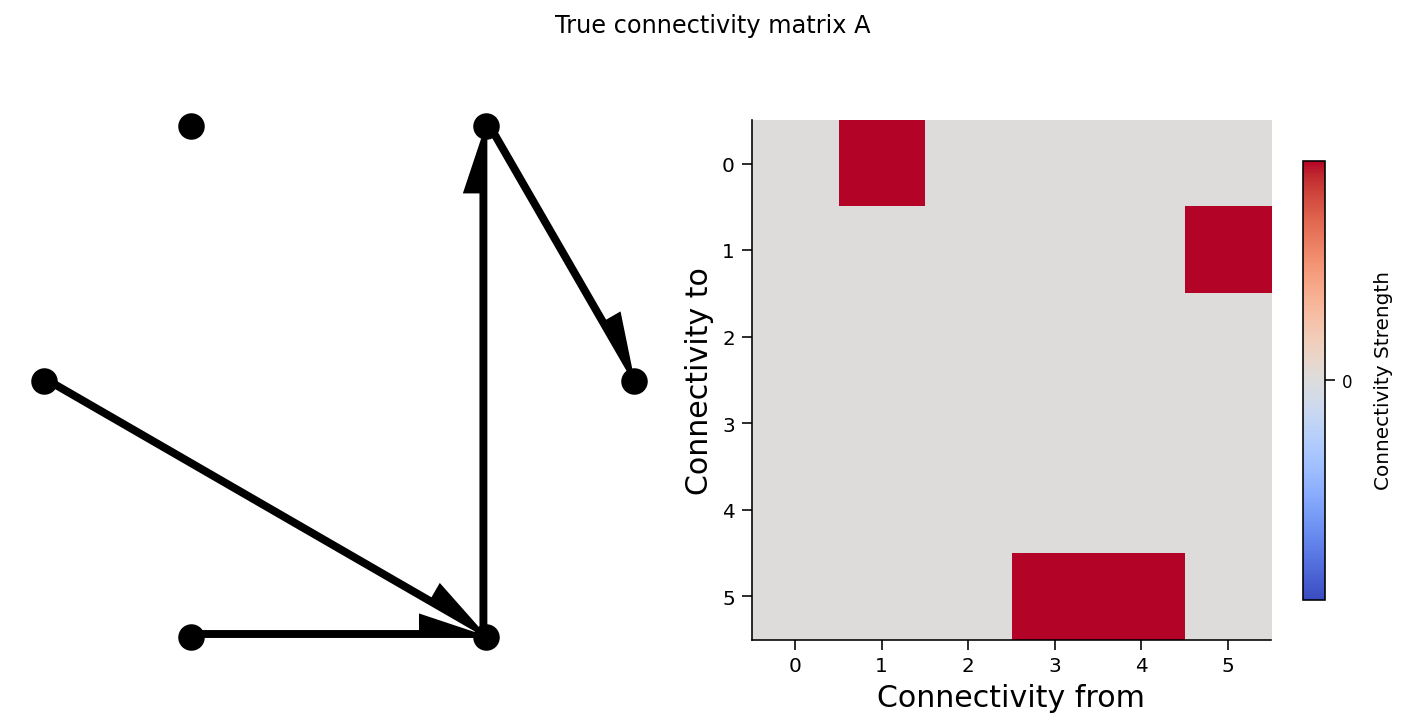

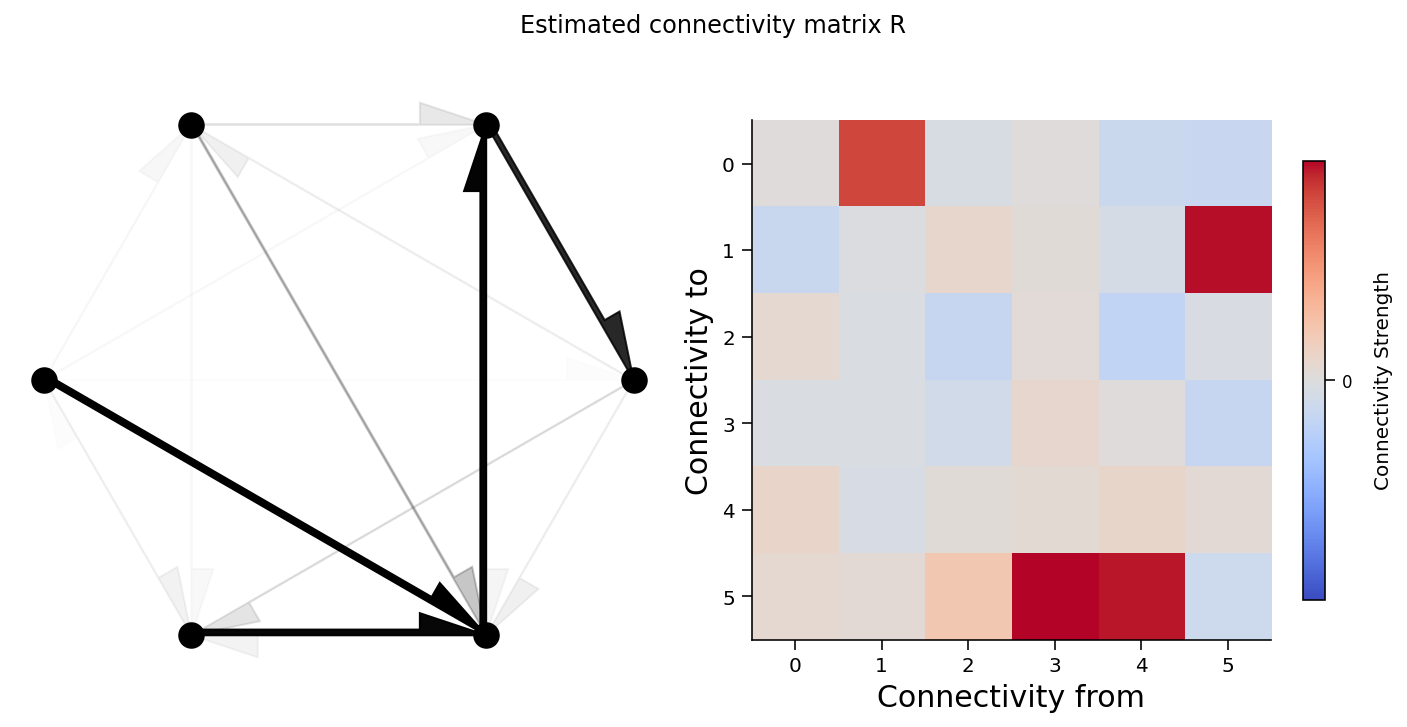

In [9]:
# @markdown Execute this cell to visualize full estimated vs true connectivity

R = correlation_for_all_neurons(X)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
see_neurons(A, axs[0])
plot_connectivity_matrix(A, ax=axs[1])
plt.suptitle("True connectivity matrix A")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
see_neurons(R, axs[0])
plot_connectivity_matrix(R, ax=axs[1])
plt.suptitle("Estimated connectivity matrix R");

That pretty much worked too. Let's quantify how much it worked. 

We'll calculate the correlation coefficient between the true connectivity and the actual connectivity;

In [10]:
print("Correlation matrix of A and R:", np.corrcoef(A.flatten(), R.flatten())[0, 1])

Correlation matrix of A and R: 0.9596667994046594


It *appears* in our system that correlation captures causality.

In [ ]:
# @title Video 2: Correlation ~ causation for small systems
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1XZ4y1u7FR", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="eWLOnTUe9SM", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

**Video correction**: the connectivity graph plots and associated explanations in this and other videos show the wrong direction of connectivity (the arrows should be pointing the opposite direction). This has been fixed in the figures above.

---
# Section 2: Large systems

*Estimated timing to here from start of tutorial: 15 min*

As our system becomes more complex however, correlation fails to capture causality.

## Section 2.1: Failure of correlation in complex systems

Let's jump to a much bigger system. Instead of 6 neurons, we will now use 100 neurons. How does the estimation quality of the connectivity matrix change? 

Correlation matrix of A and R: 0.3629329824177816


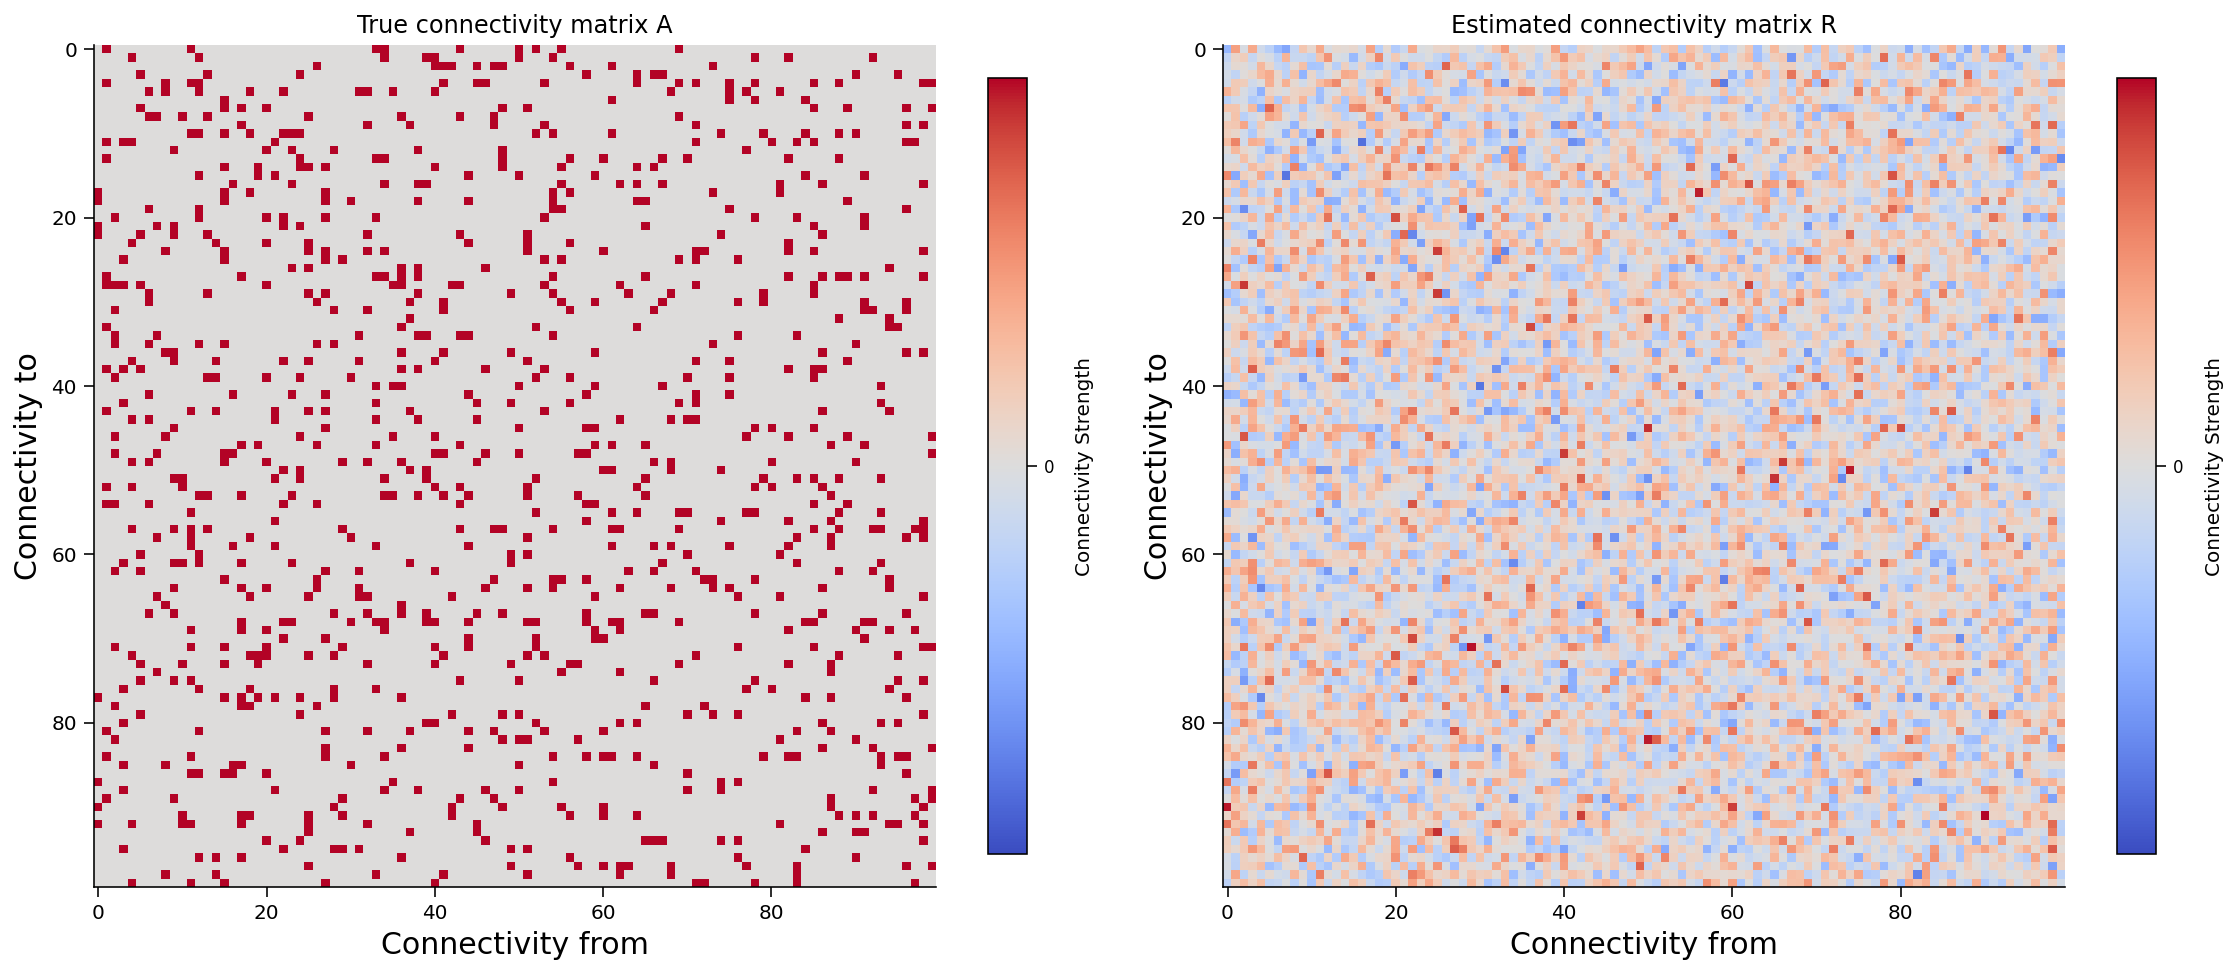

In [11]:
# @markdown Execute this cell to simulate large system, estimate connectivity matrix with correlation and return estimation quality

# Simulate a 100 neuron system for 5000 timesteps.
n_neurons = 100
timesteps = 5000
random_state = 42

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)
R = correlation_for_all_neurons(X)

print("Correlation matrix of A and R:", np.corrcoef(A.flatten(), R.flatten())[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_connectivity_matrix(A, ax=axs[0])
axs[0].set_title("True connectivity matrix A")
plot_connectivity_matrix(R, ax=axs[1])
axs[1].set_title("Estimated connectivity matrix R");

In [ ]:
# @title Video 3: Correlation vs causation in large systems
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1uC4y1b76C", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="U4sV-7g8T08", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.2: Correlation as a function of network size



### Interactive Demo 2.2.1: Connectivity estimation as a function of number of neurons

Instead of looking at just a few neurons (6) or a lot of neurons (100), as above, we will now systematically vary the number of neurons and plot the resulting changes in correlation coefficient between the true and estimated connectivity matrices. 

In [12]:
# @markdown Execute this cell to enable demo
@widgets.interact(n_neurons=(6, 42, 3))
def plot_corrs(n_neurons=6):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  timesteps = 2000
  random_state = 42
  A = create_connectivity(n_neurons, random_state)
  X = simulate_neurons(A, timesteps)
  R = correlation_for_all_neurons(X)
  corr = np.corrcoef(A.flatten(), R.flatten())[0, 1]
  plot_connectivity_matrix(A, ax=axs[0])
  plot_connectivity_matrix(R, ax=axs[1])
  axs[0].set_title("True connectivity")
  axs[1].set_title("Estimated connectivity")
  axs[2].text(0, 0.5, "Correlation : {:.2f}".format(corr), size=15)
  axs[2].axis('off')

interactive(children=(IntSlider(value=6, description='n_neurons', max=42, min=6, step=3), Output()), _dom_clas…

Of course there is some variability due to randomness in $A$. Let's average over a few trials and find the relationship.

simulating trial 1 of 5
simulating trial 2 of 5
simulating trial 3 of 5


/tmp/ipykernel_3566752/2993435089.py:31: RuntimeWarning: invalid value encountered in divide
  A = A_0 / (1.01 * s_vals[0])


simulating trial 4 of 5
simulating trial 5 of 5


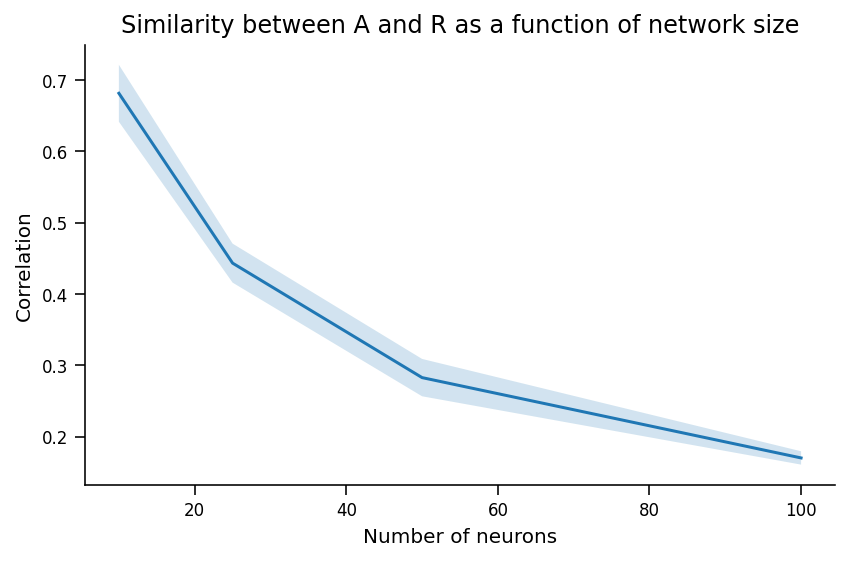

In [13]:
# @markdown Execute this cell to plot connectivity estimation as a function of network size

n_trials = 5
timesteps = 1000  # shorter timesteps for faster running time
number_of_neurons = [5, 10, 25, 50, 100]
plot_estimation_quality_vs_n_neurons(number_of_neurons)

### Interactive Demo 2.2.2: Connectivity estimation as a function of the sparsity of $A$

You may rightly wonder if correlation only fails for large systems for certain types of $A$. In this interactive demo, you can examine connectivity estimation as a function of the sparsity of $A$. Does connectivity estimation get better or worse with less sparsity?

In [14]:
# @markdown Execute this cell to enable demo
@widgets.interact(sparsity=(0.01, 0.99, .01))
def plot_corrs(sparsity=0.9):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  timesteps = 2000
  random_state = 42
  n_neurons = 25
  A = create_connectivity(n_neurons, random_state, sparsity)
  X = simulate_neurons(A, timesteps)
  R = correlation_for_all_neurons(X)
  corr=np.corrcoef(A.flatten(), R.flatten())[0, 1]
  plot_connectivity_matrix(A, ax=axs[0])
  plot_connectivity_matrix(R, ax=axs[1])
  axs[0].set_title("True connectivity")
  axs[1].set_title("Estimated connectivity")
  axs[2].text(0, 0.5, "Correlation : {:.2f}".format(corr), size=15)
  axs[2].axis('off')

interactive(children=(FloatSlider(value=0.9, description='sparsity', max=0.99, min=0.01, step=0.01), Output())…

---
# Section 3: Reflecting on causality 

*Estimated timing to here from start of tutorial: 34 min*

 ## Think! 3: Reflecting on causality 

Please discuss the following questions within groups for around 10 minutes.

* Think of a research paper you've written. Did it use previous causal knowledge (e.g. a mechanism), or ask a causal question? Try phrasing that causal relationship in the language of an intervention. ("*If I were to force $A$ to be $A'$, $B$ would...*")
* What methods for interventions exist in your area of neuroscience?
* Think about these common "filler" words. Do they imply a causal relationship, in its interventional definition? (*regulates, mediates, generates, modulates, shapes, underlies, produces, encodes, induces, enables, ensures, supports, promotes, determines*)
* What dimensionality would you (very roughly) estimate the brain to be? Would you expect correlations between neurons to give you their connectivity? Why?

---
# Summary

*Estimated timing of tutorial: 45 min*

In [ ]:
# @title Video 4: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1KK4y1x74w", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="hRyAN3yak_U", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Now for the takeaway. We know that for large systems correlation ≠ causation. But what about when we coarsely sample the large system? Do we get better at estimating the *effective* causal interaction between groups (=average of weights) from the correlation between the groups?

From our simulation above, the answer appears to be no: as the number of neurons per group increases, we don't see any significant increase in our ability to estimate the causal interaction between groups.

If you have time after completing all tutorials and are interested, please see Bonus Section 1 below for a brief discussion of correlation as a similarity metric and Bonus Section 2 to learn about causality and correlation in low resolution systems.

---
# Bonus



---
## Bonus Section 1: Correlation as similarity metric

We'd like to note here that though we make use of Pearson correlation coefficients throughout all of our tutorials to measure similarity between our estimated connectivity matrix $R$ and the ground truth connectivity $A$, this is not strictly correct usage of Pearson correlations as elements of $A$ are not normally distributed (they are in fact binary).

We use Pearson correlations as they are quick and easy to compute within the Numpy framework and provide qualitatively similar results to other correlation metrics. Other ways to compute similarities:
- [Spearman rank correlations](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), which does not require normally distributed data
- dichotomizing our estimated matrix $R$ by the median and then running concordance analysis, such as computing [Cohen's kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa)

Another thing to consider: all we want is some measure of the similarity between $A$ and $R$. Element-wise comparisons are one way to do this, but are there other ways you can think of? What about matrix similarities?

---
## Bonus Section 2: Low resolution systems

A common situation in neuroscience is that you observe the *average* activity of large groups of neurons. (Think fMRI, EEG, LFP, etc.)
We're going to simulate this effect, and ask if correlations work to recover the average causal effect of groups of neurons or areas.

**Note on the quality of the analogy**: This is not intended as a perfect analogy of the brain or fMRI. Instead, we want to ask: *in a big system in which correlations fail to estimate causality, can you at least recover average connectivity between groups?*

**Some brainy differences to remember**:
We are assuming that the connectivity is random. In real brains, the neurons that are averaged have correlated input and output connectivities. This will improve the correspondence between correlations and causality for the average effect because the system has a lower true dimensionality. However, in real brains the system is also order of magnitudes larger than what we examine here, and the experimenter never has the fully-observed system.

## Simulate a large system

Execute the next cell to simulate a large system of 256 neurons for 10000 timesteps - it will take a bit of time to finish so move on as it runs.

In [15]:
# @markdown Execute this cell to simulate a large system

n_neurons = 256
timesteps = 10000
random_state = 42

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)

### Bonus Section 1.1: Coarsely sample the system

We don't observe this system. Instead, we observe the average activity of groups.


#### Bonus Coding Exercise 1.1: Compute average activity across groups and compare resulting connectivity to the truth
 
Let's get a new matrix `coarse_X` that has 16 groups, each reflecting the average activity of 16 neurons (since there are 256 neurons in total).

We will then define the true coarse connectivity as the average of the neuronal connection strengths between groups. We'll compute the correlation between our coarsely sampled groups to estimate the connectivity and compare with the true connectivity.

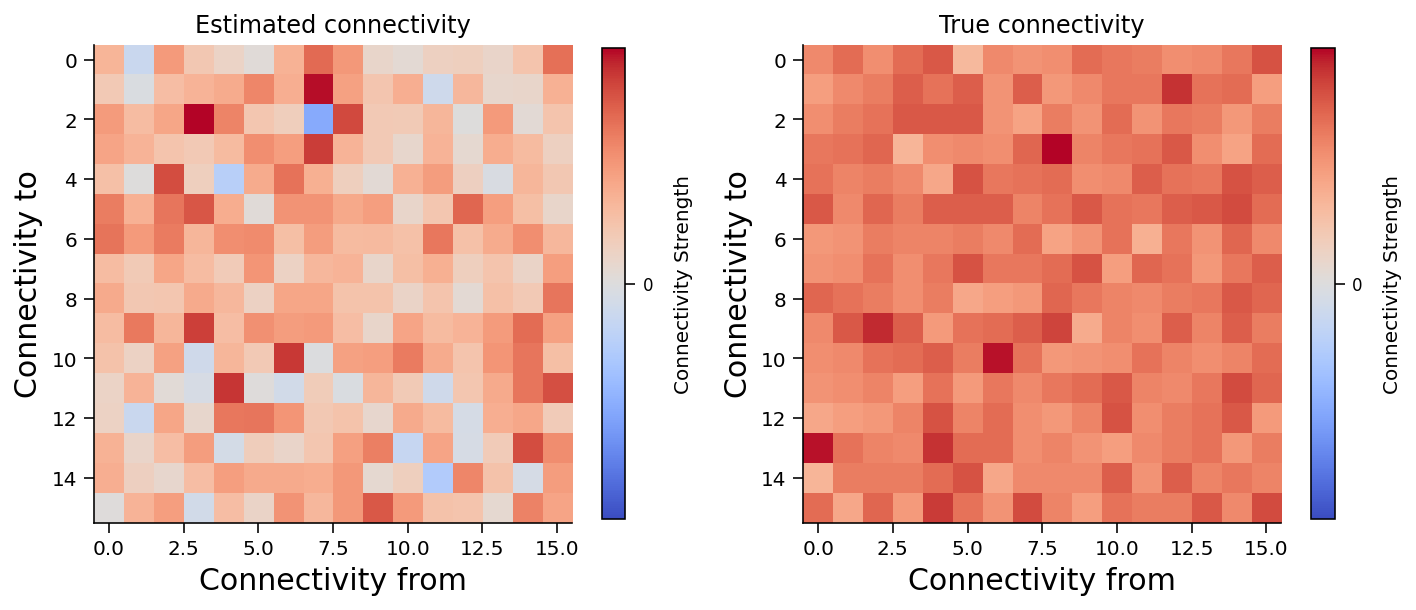

In [17]:
def get_coarse_corr(n_groups, X):
    """
    A wrapper function for our correlation calculations between coarsely sampled
    A and R.

    Args:
        n_groups (int): the number of groups. should divide the number of neurons evenly
        X: the simulated system

    Returns:
        A single float correlation value representing the similarity between A and R
        ndarray: estimated connectivity matrix
        ndarray: true connectivity matrix
    """

    ############################################################################
    ##  Insert your code here to get coarsely sampled X
    # Fill out function then remove
    ############################################################################
    
    coarse_X = X.reshape(n_groups, n_neurons // n_groups, timesteps).mean(1)

    # Make sure coarse_X is the right shape
    assert coarse_X.shape == (n_groups, timesteps)

    # Estimate connectivity from coarse system
    R = correlation_for_all_neurons(coarse_X)

    # Compute true coarse connectivity
    coarse_A = A.reshape(n_groups, n_neurons // n_groups, n_groups, n_neurons // n_groups).mean(3).mean(1)

    # Compute true vs estimated connectivity correlation
    corr = np.corrcoef(coarse_A.flatten(), R.flatten())[0, 1]

    return corr, R, coarse_A


n_groups = 16

# Call function
corr, R, coarse_A = get_coarse_corr(n_groups, X)

# Visualize
plot_true_vs_estimated_connectivity(R, coarse_A)

How close is the estimated coarse connectivity matrix to the truth?

In [18]:
print("Correlation: {}".format(corr))

Correlation: 0.1871085307158572


We will now look at the estimation quality for different levels of coarseness when averaged over 3 trials.

Trial 0 out of 3
Trial 1 out of 3
Trial 2 out of 3


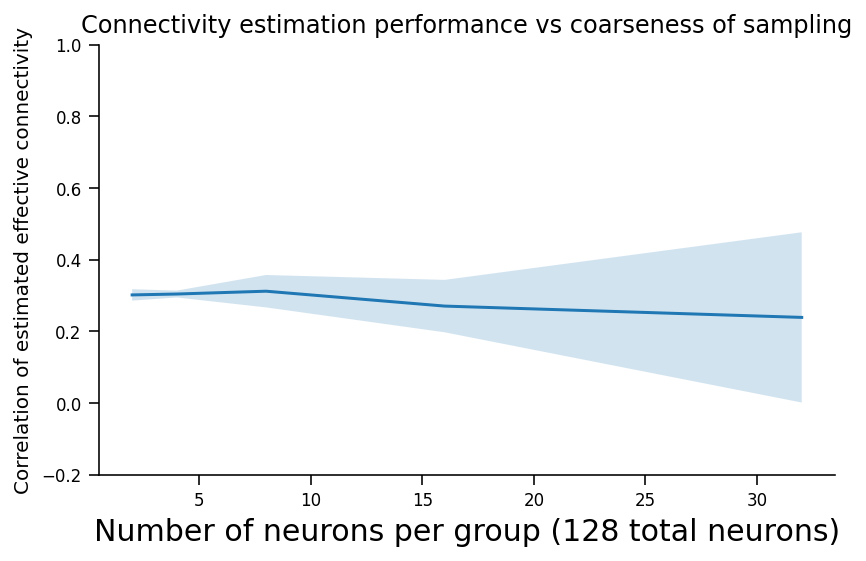

In [19]:
#@markdown Execute this cell to visualize plot

n_neurons = 128
timesteps = 5000
n_trials = 3
groups = [2 ** i for i in range(2, int(np.log2(n_neurons)))]

corr_data = np.zeros((n_trials, len(groups)))

for trial in range(n_trials):
    print("Trial {} out of {}".format(trial, n_trials))
    A = create_connectivity(n_neurons, random_state=trial)
    X = simulate_neurons(A, timesteps, random_state=trial)
    for j, n_groups in enumerate(groups):
        corr_data[trial, j], _, _ = get_coarse_corr(n_groups, X)

corr_mean = corr_data.mean(axis=0)
corr_std = corr_data.std(axis=0)

plt.plot(np.divide(n_neurons, groups), corr_mean)
plt.fill_between(np.divide(n_neurons, groups),
                  corr_mean - corr_std,
                  corr_mean + corr_std,
                  alpha=.2)

plt.ylim([-0.2, 1])
plt.xlabel("Number of neurons per group ({} total neurons)".format(n_neurons),
        fontsize=15)
plt.ylabel("Correlation of estimated effective connectivity")
plt.title("Connectivity estimation performance vs coarseness of sampling")
plt.show()

We know that for large systems correlation $\neq$ causation. Here, we have looked at what happens when we coarsely sample a large system. Do we get better at estimating the *effective* causal interaction between groups (=average of weights) from the correlation between the groups?

From our simulation above, the answer appears to be no: as the number of neurons per group increases, we don't see any significant increase in our ability to estimate the causal interaction between groups.